Import

In [46]:
import subprocess
import shlex
import os.path
import sys
import pickle
import datetime
import tweepy
import matplotlib.pyplot as plt 
import numpy as np
from scipy import spatial  
from sklearn.metrics import r2_score
import string
import numpy as np
import matplotlib.pyplot as plt
import collections
from itertools import tee, islice
from sklearn.decomposition import PCA
import math

Other Helper Functions

In [2]:
def get_list_of_users(tweets):

    list_of_user = []

    for tweet in tweets:
        user_id = tweet.user.id
        if user_id not in list_of_user:
            list_of_user.append(user_id)

    return list_of_user

Import Tweet and Related Data

In [ ]:
# Where you want to save the coverted files # TO BE REMOVED
test_directory = "" 

In [3]:
#Location of all the ".p" files containing tweets of friends
directory = "L:/Users/Daniel/Documents/2020-2021/2021 Winter Courses/COG403/Assignments/Project/Python Tweets/" 

# Location of sentiment analysis file
sentiment_directory = "L:/Users/Daniel/Documents/2020-2021/2021 Winter Courses/COG403/Assignments/Project/Python Tweets/Sentiment/"
analyzed_users = "L:/Users/Daniel/Documents/2020-2021/2021 Winter Courses/COG403/Assignments/Project/Python Tweets/data_analyzed_1.p"

In [4]:
# Tweets output from the function, get_inital_tweets
initial_tweet_file = directory + 'user_tweet_large.p'
initial_tweets = pickle.load(open(initial_tweet_file, "rb"))
trending_tweet_file = directory + 'trending_tweets.p'
trending_tweets = pickle.load(open(trending_tweet_file, "rb"))

In [5]:
print(len(trending_tweets))
list_of_users = get_list_of_users(trending_tweets)

740


In [3]:
# Don't use this if using above
already_analyzed = pickle.load(open(analyzed_users, "rb"))
list_of_users = []

for uid in already_analyzed:
    list_of_users.append(uid)

PCA Model

In [18]:
# Number of tweets in database
all_tweets = 0

for user in list_of_users:
    
    file_name = sentiment_directory + str(user) + '_sent.p'
    
    if os.path.exists(file_name):
        
        tweet_sentiment = pickle.load(open(file_name, "rb"))
        
        num_of_tweets_user = len(tweet_sentiment)
        all_tweets = all_tweets + num_of_tweets_user

In [20]:
# Number of features
num_of_features = 19
print(all_tweets)
print(num_of_features)

26232
19


In [21]:
# 0 = 0avg, 5 = 5 avg, 6 = -1 avg, 10 = -5 avg
C = []

for i in range(11):
    C.append([])

In [27]:
u_index = 0
# Analyze all the  users in initial_tweets
for user in list_of_users:
    print("Analyzing user " + str(u_index))
    u_index += 1
    
    file_name = sentiment_directory + str(user) + '_sent.p'
    
    if os.path.exists(file_name):
        
        tweet_sentiment = pickle.load(open(file_name, "rb"))
        
        for tweet_id in tweet_sentiment:
            # 0-0avg, 5 = 5avg, 6=pos_1, 10=pos_5, 11=neg_1, 15=neg_5, 16=pos, 17=neg, 18=neu
            values = np.zeros(num_of_features)
            
            tweet_sent = tweet_sentiment[tweet_id]['combined']

            if 'friend' in tweet_sentiment[tweet_id]:
                for tweet in tweet_sentiment[tweet_id]['friend']:
                    
                    friend_sentiment = tweet_sentiment[tweet_id]['friend'][tweet]['combined']
                    values[friend_sentiment] += 1
                    if friend_sentiment > 0:
                        values[16] += 1
                    elif friend_sentiment < 0:
                        values[17] += 1
                    else:
                        values[18] += 1
                        
                    friend_separate = tweet_sentiment[tweet_id]['friend'][tweet]
                    friend_separe_positive = tweet_sentiment[tweet_id]['friend'][tweet]['sentiment'][0]
                    values[5 + friend_separe_positive] += 1
                    friend_separe_negative = tweet_sentiment[tweet_id]['friend'][tweet]['sentiment'][1]
                    values[10 + abs(friend_separe_negative)] += 1
                            
                total = values[16] + values[17] + values[18]
                
                if total > 0:
                    values[16] = values[16]/total
                    values[17] = values[17]/total
                    values[18] = values[18]/total
                    
                    if 5 >= tweet_sent >= 0:
                        C[tweet_sent].append(values)
                    else:
                        C[5 + abs(tweet_sent)].append(values)
                        
flat_c = []
size = []

# Convert into array such that row = num of tweets and column = features
for l in C:
    size.append(len(l))
    for item in l:
        flat_c.append(item)


Analyzing user 0
Analyzing user 1
Analyzing user 2
Analyzing user 3
Analyzing user 4
Analyzing user 5
Analyzing user 6
Analyzing user 7
Analyzing user 8
Analyzing user 9
Analyzing user 10
Analyzing user 11
Analyzing user 12
Analyzing user 13
Analyzing user 14
Analyzing user 15
Analyzing user 16
Analyzing user 17
Analyzing user 18
Analyzing user 19
Analyzing user 20
Analyzing user 21
Analyzing user 22
Analyzing user 23
Analyzing user 24
Analyzing user 25
Analyzing user 26
Analyzing user 27
Analyzing user 28
Analyzing user 29
Analyzing user 30
Analyzing user 31
Analyzing user 32
Analyzing user 33
Analyzing user 34
Analyzing user 35
Analyzing user 36
Analyzing user 37
Analyzing user 38
Analyzing user 39
Analyzing user 40
Analyzing user 41
Analyzing user 42
Analyzing user 43
Analyzing user 44
Analyzing user 45
Analyzing user 46
Analyzing user 47
Analyzing user 48
Analyzing user 49
Analyzing user 50
Analyzing user 51
Analyzing user 52
Analyzing user 53
Analyzing user 54
Analyzing user 55
An

[[ -94.00389316  -28.21951265]
 [ -26.21070616  -36.47994533]
 [ -27.04668845  -36.12338859]
 ...
 [-135.29731078  -47.48761691]
 [-142.81453679  -43.34687541]
 [-122.77929564  -55.56869986]]


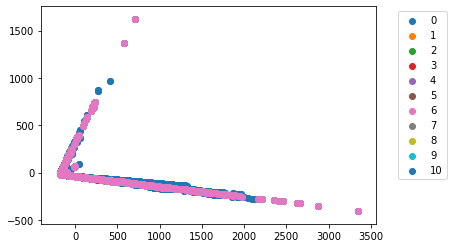

In [30]:
# Specify number of component to keep
pca = PCA(n_components=2)
# Fit the model with the matrix flat_C, where row = samples, column = feature
pca.fit(flat_c)
# Apply dimensionality reduction on matrix flat_c, which return row = samples, columns = components (PC1 (most variation), PC2)
C_pca = pca.transform(flat_c)

print(C_pca)

for i in range(len(size)):
    if i != 0:
        plt.scatter(C_pca[size[i - 1]:size[i]+1, 0], C_pca[size[i - 1]:size[i]+1, 1], label=str(i))
    else:
        plt.scatter(C_pca[0:size[i]+1, 0], C_pca[0:size[i]+1, 1], label=str(i))
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

PCA

[[-2.09337695e+04 -9.59016528e+01]
 [-2.09337695e+04 -9.59016528e+01]
 [-1.44048874e+04 -5.28311182e+01]
 [-3.93687994e+03 -2.82097769e+01]
 [-3.48559366e+01 -1.35300322e+00]
 [ 9.19316030e+04 -3.02651489e+02]
 [ 2.52212259e+04  6.67479048e+02]
 [ 1.77711932e+03  2.04905361e+02]
 [-1.68405569e+04 -1.09328453e+02]
 [-2.09114595e+04 -9.03056107e+01]
 [-2.09337695e+04 -9.59016528e+01]]


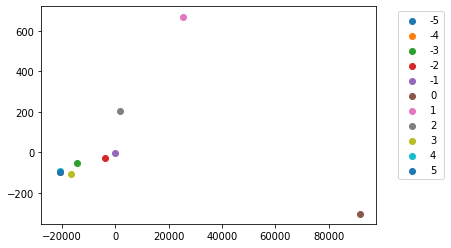

In [44]:
import string
import numpy as np
import matplotlib.pyplot as plt
import collections
from itertools import tee, islice
from sklearn.decomposition import PCA

scale = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
overall = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
excluded = [0, 1]

C = np.zeros((11, 11))

# Analyze all the  users in initial_tweets
for user in list_of_users:
    
    file_name = sentiment_directory + str(user) + '_sent.p'
    
    if os.path.exists(file_name):
        
        tweet_sentiment = pickle.load(open(file_name, "rb"))
        
        for tweet_id in tweet_sentiment:
            tweet_sent_index = overall.index(tweet_sentiment[tweet_id]['combined'])
            
            if 'friend' in tweet_sentiment[tweet_id]:
                for tweet in tweet_sentiment[tweet_id]['friend']:
                    friend_index = overall.index(tweet_sentiment[tweet_id]['friend'][tweet]['combined'])
                    C[tweet_sent_index][friend_index] += 1
                    
# Specify number of component to keep
pca = PCA(n_components=2)
# Fit the model with the matrix C, where row = samples, column = feature
pca.fit(C)
# Apply dimensionality reduction on matrix c, which return row = samples, columns = components (PC1 (most variation), PC2)
C_pca = pca.transform(C)

print(C_pca)

for i in range(len(overall)):
    plt.scatter(C_pca[i:i+1, 0], C_pca[i:i+1, 1], label=overall[i])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

3D Plot

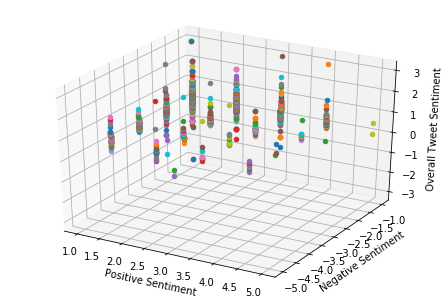

In [12]:
from mpl_toolkits.mplot3d import Axes3D

x_1 = []
y_1 = []
z_1 = []

fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("Positive Sentiment")
ax.set_ylabel("Negative Sentiment")
ax.set_zlabel("Overall Tweet Sentiment")

# Analyze all the  users in initial_tweets
for user in list_of_users:
    
    file_name = sentiment_directory + str(user) + '_sent.p'
    
    if os.path.exists(file_name):
        
        tweet_sentiment = pickle.load(open(file_name, "rb"))
        
        for tweet_id in tweet_sentiment:
            if 'friend' in tweet_sentiment[tweet_id]:
                x_temp = tweet_sentiment[tweet_id]['sentiment'][0]
                y_temp = tweet_sentiment[tweet_id]['sentiment'][1]
                x_1.append(x_temp)
                y_1.append(y_temp)
                z_1.append(tweet_sentiment[tweet_id]['friend'])
                ax.scatter(x_temp, y_temp, tweet_sentiment[tweet_id]['friend'])
            
x_1 = np.array(x_1)
y_1 = np.array(y_1)
z_1 = np.array(z_1)

PCA 1D

[[-5756.72921788]
 [-5756.72921788]
 [-2617.01541367]
 [ 2142.65656737]
 [ 6181.54030341]
 [-5756.72921788]
 [19480.635701  ]
 [ 7449.84244472]
 [-3868.1826734 ]
 [-5742.56005792]
 [-5756.72921788]]


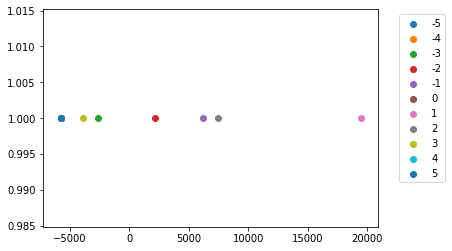

In [84]:
import string
import numpy as np
import matplotlib.pyplot as plt
import collections
from itertools import tee, islice
from sklearn.decomposition import PCA

scale = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
overall = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
excluded = [0]

C = np.zeros((11, 11))

# Analyze all the  users in initial_tweets
for user in list_of_users:
    
    file_name = sentiment_directory + str(user) + '_sent.p'
    
    if os.path.exists(file_name):
        
        tweet_sentiment = pickle.load(open(file_name, "rb"))
        
        for tweet_id in tweet_sentiment:
            
            if tweet_sentiment[tweet_id]['combined'] not in excluded:
                tweet_sent_index = overall.index(tweet_sentiment[tweet_id]['combined'])

                if 'friend' in tweet_sentiment[tweet_id]:
                    for tweet in tweet_sentiment[tweet_id]['friend']:
                        if tweet_sentiment[tweet_id]['friend'][tweet]['combined'] not in excluded:
                            friend_index = overall.index(tweet_sentiment[tweet_id]['friend'][tweet]['combined'])
                            C[tweet_sent_index][friend_index] += 1
                    
# Specify number of component to keep
pca = PCA(n_components=1)
# Fit the model with the matrix C, where row = samples, column = feature
pca.fit(C)
# Apply dimensionality reduction on matrix c, which return row = samples, columns = components (PC1 (most variation), PC2)
C_pca = pca.transform(C)

print(C_pca)

for i in range(len(overall)):
    plt.scatter(C_pca[i:i+1, 0], 1, label=overall[i])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Experimental Code

Chart Showing Relationship between Positive Sentiment, Negative Sentiment and Neutral Sentiment 

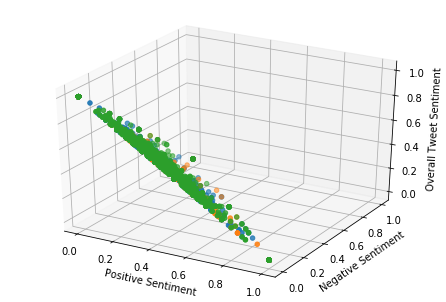

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("Positive Sentiment")
ax.set_ylabel("Negative Sentiment")
ax.set_zlabel("Neutral Tweet Sentiment")

ax.scatter(positive_x, positive_y, positive_z, label='postive')
ax.scatter(negative_x, negative_y, negative_z, label='negative')
ax.scatter(neutral_x, neutral_y, neutral_z, label='neutral')

SVM - Experimental

In [46]:
from sklearn import svm

positive_label = np.zeros(len(positive_data_point))
negative_label = np.ones(len(negative_data_point))
neutral_label = np.zeros(len(neutral_data_point))

for i in range(len(neutral_label)):
    neutral_label[i] = 2

positive_label = positive_label.tolist()
negative_label = negative_label.tolist()
neutral_label = neutral_label.tolist()

all_labels = positive_label + negative_label #+ neutral_label
all_labels = np.asarray(all_labels)


'''
positive_data_point = positive_data_point.tolist()
negative_data_point = negative_data_point.tolist()
neutral_data_point = neutral_data_point.tolist()
'''

all_points = positive_data_point + negative_data_point #+ neutral_data_point
all_points = np.asarray(all_points)
print(all_points)

clf = svm.SVC() #svm.NuSVC(gamma='auto') #kernel='poly', probability=True
clf.fit(all_points, all_labels)
tech = clf.predict([[0.2, 0.3, 0.5]])
print(int(tech[0]))

[[0.23611111 0.27777778 0.48611111]
 [0.22018349 0.29357798 0.48623853]
 [0.27350427 0.31623932 0.41025641]
 ...
 [0.35416667 0.13541667 0.51041667]
 [0.33333333 0.13131313 0.53535354]
 [0.32653061 0.10204082 0.57142857]]
0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [47]:
total_count = 0
accurate = 0

p_total = 0
p_acc = 0

n_total = 0
n_acc = 0

ne_total = 0
ne_acc = 0

for user in list_of_users_NZ:
    
    file_name = predictive_model + str(user) + '_sent.p'
    
    if os.path.exists(file_name):
        
        tweet_sentiment = pickle.load(open(file_name, "rb"))
        
        for tweet_id in tweet_sentiment:

            positive = 0
            negative = 0
            neutral = 0
            
            tweet_sent = tweet_sentiment[tweet_id]['combined']
            
            if tweet_sent != 0:

                if 'friend' in tweet_sentiment[tweet_id]:
                    for tweet in tweet_sentiment[tweet_id]['friend']:

                        friend_sentiment = tweet_sentiment[tweet_id]['friend'][tweet]['combined']
                        if friend_sentiment > 0:
                            positive += 1
                        elif friend_sentiment < 0:
                            negative += 1
                        else:
                            neutral += 1

                total = positive + negative + neutral
                if total > 0:
                    positve_percent = positive/total
                    negative_percent = negative/total
                    neutral_percent = neutral/total
                    temp = [positve_percent, negative_percent, neutral_percent]
                    temp = np.asarray(temp)

                    exemplar = int(clf.predict([temp])[0])
                    total_count += 1

                    if tweet_sent > 0:
                        p_total += 1
                        if exemplar == 0:
                            accurate += 1
                            p_acc += 1
                    elif tweet_sent < 0:
                        n_total += 1
                        if exemplar == 1:
                            accurate += 1
                            n_acc += 1
                    else:
                        ne_total += 1
                        if exemplar == 2:
                            accurate += 1
                            ne_acc += 1

In [48]:
# when just predicting neutral from others for prototype when sent=0, 0, svm
print(accurate)
print(total_count)
print(p_acc/p_total)
print(n_acc/n_total)
#print(ne_acc/ne_total)
print(accurate/total_count)

500
777
1.0
0.0
0.6435006435006435
